In [27]:
import pandas as pd

# EXP Smoothing( state level)

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')

import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0117.csv')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-20']

hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])
quantile_result2['location'] = quantile_result2['location'].astype(str).str.zfill(2)

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Regional LSTM

## Generate quantile prediction

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/weightselection/region/allresulttest0110.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [ ]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-4-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-4-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-4-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-4-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'

,fips,Week_end,horizon,Quantile,Value
0,01,2024-01-06,0,0.010,126.99
1,01,2024-01-06,0,0.025,138.95
2,01,2024-01-06,0,0.050,150.00
3,01,2024-01-06,0,0.100,170.00
4,01,2024-01-06,0,0.150,180.85
...,...,...,...,...,...
4595,56,2024-01-06,3,0.850,30.00
4596,56,2024-01-06,3,0.900,31.10
4597,56,2024-01-06,3,0.950,35.00
4598,56,2024-01-06,3,0.975,39.00


In [ ]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,01,2024-01-13,0,0.010,126.99
1,01,2024-01-13,0,0.025,138.95
2,01,2024-01-13,0,0.050,150.00
3,01,2024-01-13,0,0.100,170.00
4,01,2024-01-13,0,0.150,180.85
...,...,...,...,...,...
4595,56,2024-01-13,3,0.850,30.00
4596,56,2024-01-13,3,0.900,31.10
4597,56,2024-01-13,3,0.950,35.00
4598,56,2024-01-13,3,0.975,39.00


In [ ]:
import csv
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
#quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0117.csv',index = False)
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.010,126.99
1,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.025,138.95
2,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.050,150.00
3,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.100,170.00
4,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.150,180.85
...,...,...,...,...,...,...,...,...
4595,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.850,30.00
4596,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.900,31.10
4597,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.950,35.00
4598,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.975,39.00


## Plot admission at each location

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-01-20** (training set: after 2022-08)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0117.csv')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-13']

hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# LSTM

## Generate quantile prediction

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/weightselection/allresulttest1.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [ ]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-22-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-22-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-22-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-22-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFram

,fips,Week_end,horizon,Quantile,Value
0,1,2024-01-20,0,0.010,130.000
1,1,2024-01-20,0,0.025,143.975
2,1,2024-01-20,0,0.050,150.000
3,1,2024-01-20,0,0.100,161.900
4,1,2024-01-20,0,0.150,169.000
...,...,...,...,...,...
4595,56,2024-01-20,3,0.850,28.150
4596,56,2024-01-20,3,0.900,30.000
4597,56,2024-01-20,3,0.950,33.000
4598,56,2024-01-20,3,0.975,35.000


In [ ]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,1,2024-01-27,0,0.010,130.000
1,1,2024-01-27,0,0.025,143.975
2,1,2024-01-27,0,0.050,150.000
3,1,2024-01-27,0,0.100,161.900
4,1,2024-01-27,0,0.150,169.000
...,...,...,...,...,...
4595,56,2024-01-27,3,0.850,28.150
4596,56,2024-01-27,3,0.900,30.000
4597,56,2024-01-27,3,0.950,33.000
4598,56,2024-01-27,3,0.975,35.000


In [ ]:
import csv
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
#quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0117.csv',index = False)
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.010,130.000
1,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.025,143.975
2,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.050,150.000
3,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.100,161.900
4,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.150,169.000
...,...,...,...,...,...,...,...,...
4595,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.850,28.150
4596,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.900,30.000
4597,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.950,33.000
4598,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.975,35.000


## Plot admission at each location

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-01-13** (training set: after 2022-08)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-27']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### **2024-01-20**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0117.csv')
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-20']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), quantile_result2['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# GRU

## Generate quantile prediction

In [29]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/GRU/weightselection/allresulttest1.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df

In [30]:
import numpy as np


quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result

<ipython-input-30-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-30-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-30-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-30-de04dbb159fc>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFram

,fips,Week_end,horizon,Quantile,Value
0,1,2024-01-20,0,0.010,76.97
1,1,2024-01-20,0,0.025,86.00
2,1,2024-01-20,0,0.050,93.00
3,1,2024-01-20,0,0.100,102.90
4,1,2024-01-20,0,0.150,111.00
...,...,...,...,...,...
4595,56,2024-01-20,3,0.850,23.00
4596,56,2024-01-20,3,0.900,24.00
4597,56,2024-01-20,3,0.950,26.00
4598,56,2024-01-20,3,0.975,28.00


In [31]:
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,1,2024-01-27,0,0.010,76.97
1,1,2024-01-27,0,0.025,86.00
2,1,2024-01-27,0,0.050,93.00
3,1,2024-01-27,0,0.100,102.90
4,1,2024-01-27,0,0.150,111.00
...,...,...,...,...,...
4595,56,2024-01-27,3,0.850,23.00
4596,56,2024-01-27,3,0.900,24.00
4597,56,2024-01-27,3,0.950,26.00
4598,56,2024-01-27,3,0.975,28.00


In [32]:
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.010,76.97
1,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.025,86.00
2,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.050,93.00
3,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.100,102.90
4,2024-01-27,wk inc flu hosp,0,2024-01-27,01,quantile,0.150,111.00
...,...,...,...,...,...,...,...,...
4595,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.850,23.00
4596,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.900,24.00
4597,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.950,26.00
4598,2024-01-27,wk inc flu hosp,3,2024-02-17,56,quantile,0.975,28.00


In [ ]:
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest0117.csv',index = False)

## Plot admission at each location

In [33]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


### **2024-01-13** (training set: after 2022-08)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest011.csv')
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-13']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

### **2024-01-13**(training set: after 2023)

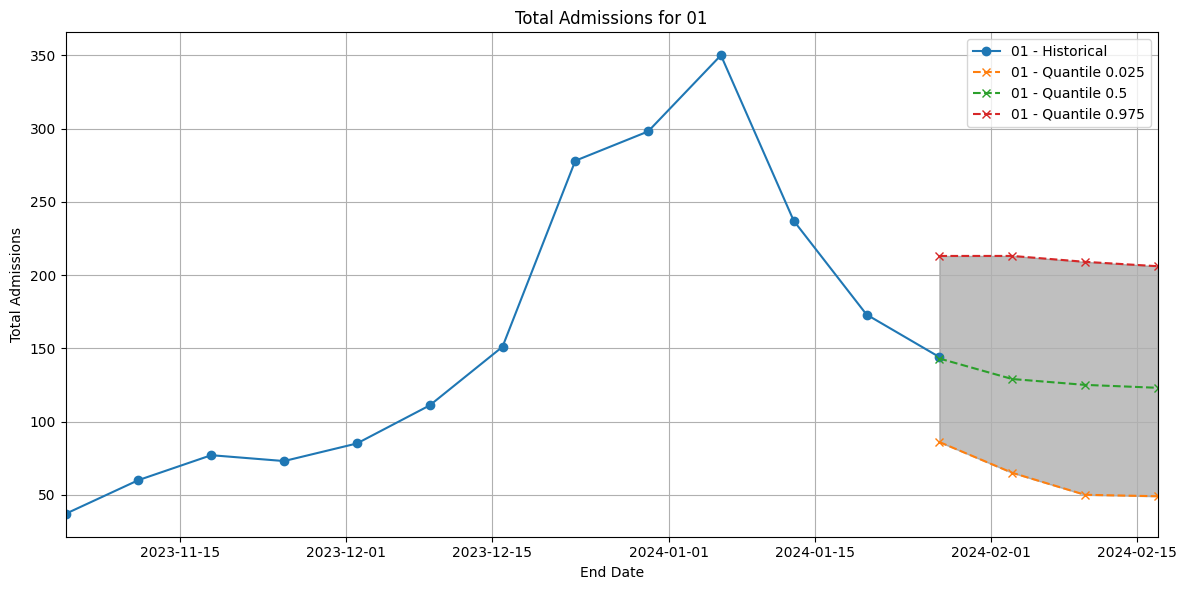

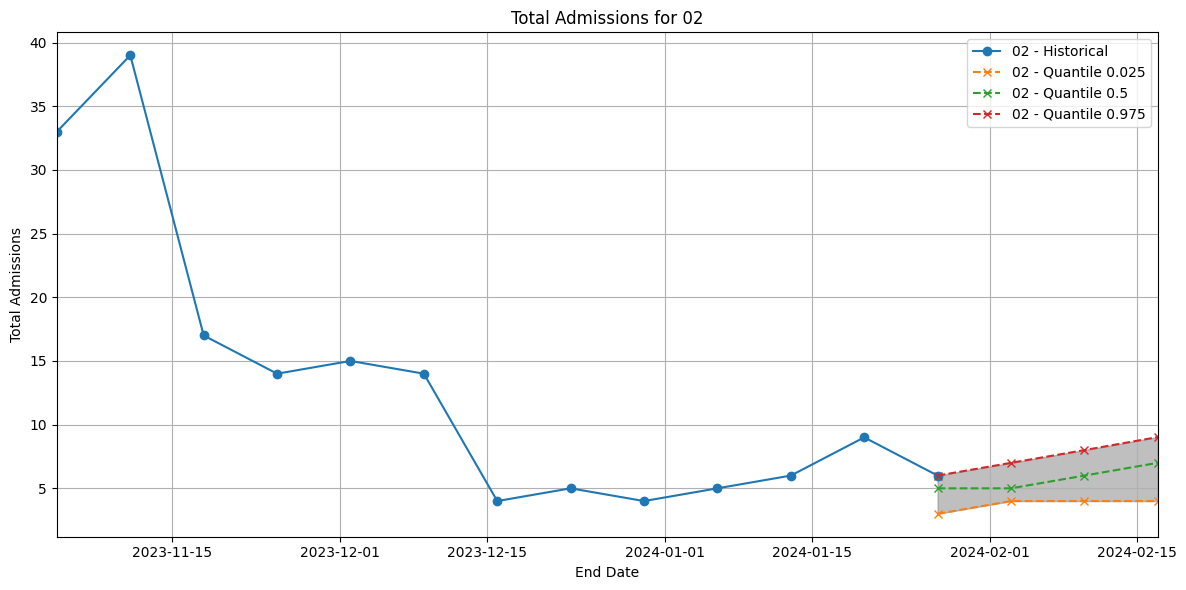

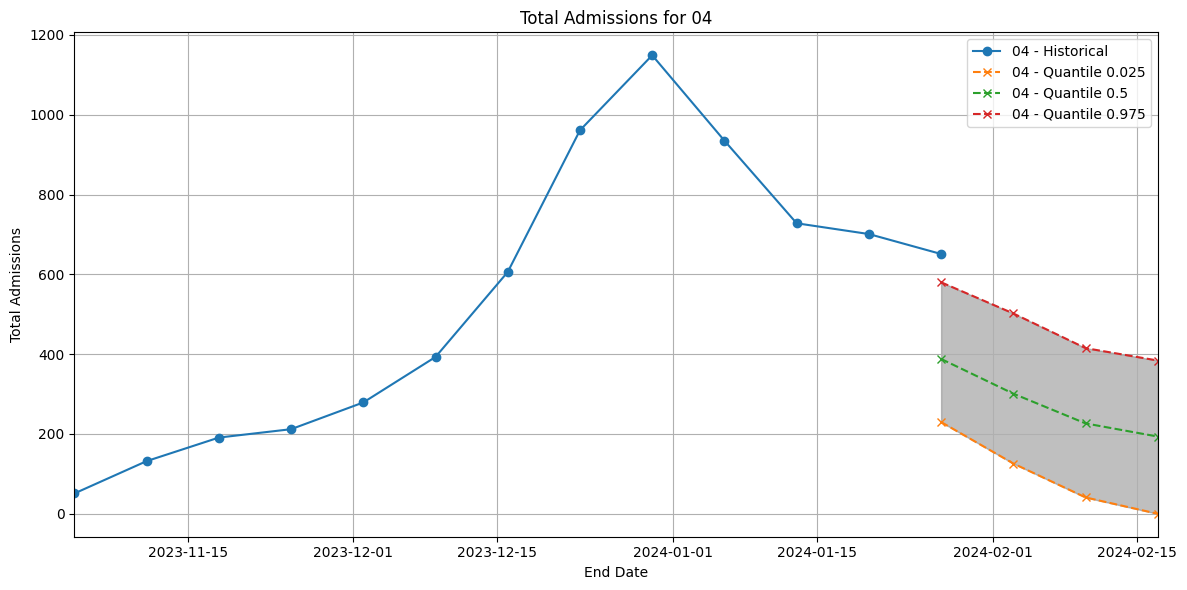

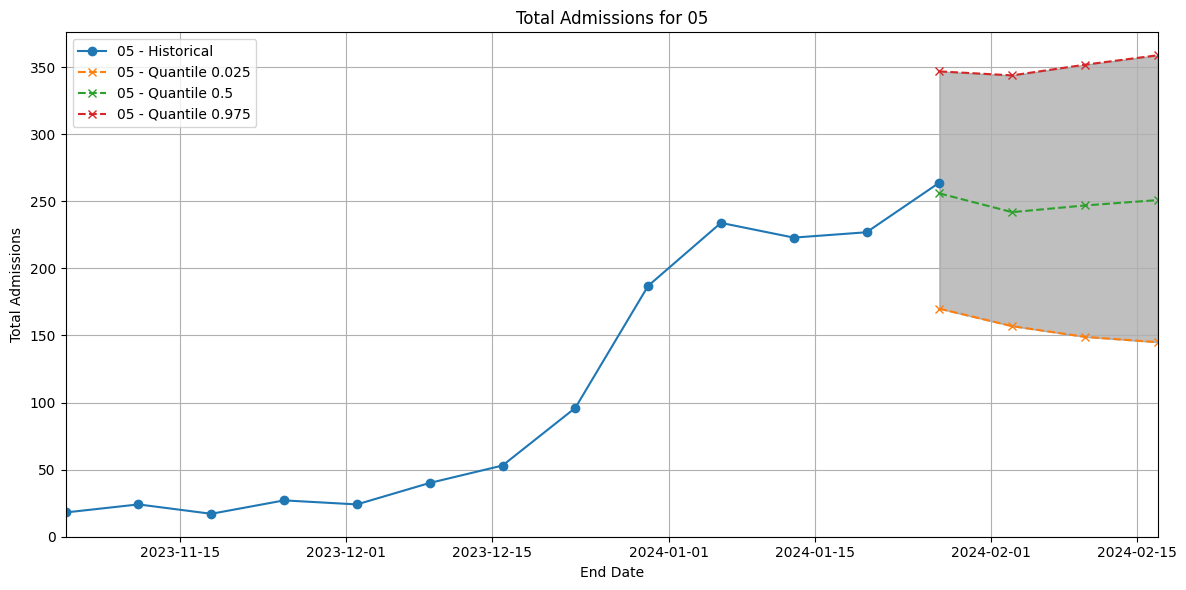

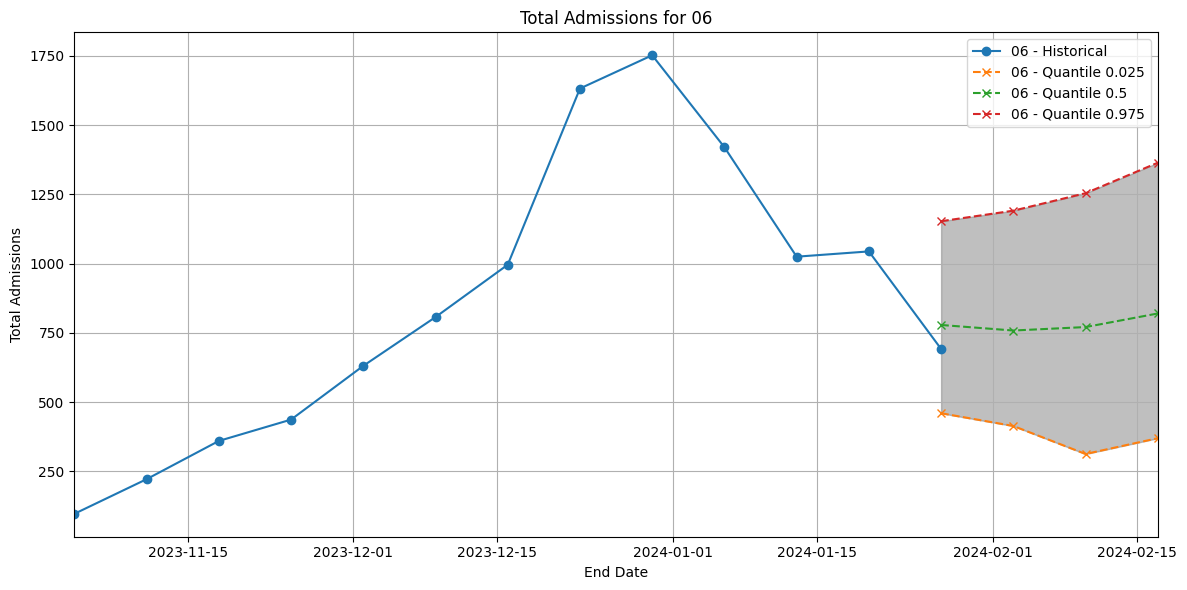

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-27']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


# LSTM+GRU

## 2024-01-13 (after 2022-08)

## modification

In [ ]:
import numpy as np
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0110.csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest0110.csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru])
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')


result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
result_df.loc[result_df['location'] == 1, 'value'] += 20
result_df.loc[(result_df['location'] == 10) & (result_df['horizon'] == 0), 'value'] -= 12
result_df.loc[(result_df['location'] == 10) & (result_df['horizon'] == 1), 'value'] -= 20
result_df.loc[(result_df['location'] == 10) & (result_df['horizon'] == 2), 'value'] -= 25
result_df.loc[(result_df['location'] == 10) & (result_df['horizon'] == 3), 'value'] -= 25

result_df.loc[(result_df['location'] == 19) & (result_df['horizon'] == 1), 'value'] -= 20
result_df.loc[(result_df['location'] == 19) & (result_df['horizon'] == 2), 'value'] -= 22
result_df.loc[(result_df['location'] == 19) & (result_df['horizon'] == 3), 'value'] -= 28

result_df.loc[(result_df['location'] == 33) & (result_df['horizon'] == 0), 'value'] -= 15
result_df.loc[(result_df['location'] == 33) & (result_df['horizon'] == 1), 'value'] -= 25
result_df.loc[(result_df['location'] == 33) & (result_df['horizon'] == 2), 'value'] -= 25
result_df.loc[(result_df['location'] == 33) & (result_df['horizon'] == 3), 'value'] -= 30
result_df.loc[result_df['location'] == 35, 'value'] += 50

result_df.loc[(result_df['location'] == 45) & (result_df['horizon'] == 0), 'value'] -= 200
result_df.loc[(result_df['location'] == 45) & (result_df['horizon'] == 1), 'value'] -= 50
result_df.loc[(result_df['location'] == 45) & (result_df['horizon'] == 2), 'value'] -= 50
result_df.loc[(result_df['location'] == 45) & (result_df['horizon'] == 3), 'value'] -= 50

result_df.loc[(result_df['location'] == 49) & (result_df['horizon'] == 0), 'value'] -= 80
result_df.loc[(result_df['location'] == 49) & (result_df['horizon'] == 1), 'value'] -= 80
result_df.loc[(result_df['location'] == 49) & (result_df['horizon'] == 2), 'value'] -= 50
result_df.loc[(result_df['location'] == 49) & (result_df['horizon'] == 3), 'value'] -= 40

result_df['location'] = result_df['location'].astype(str).str.zfill(2)
result_df['location'] = result_df['location'].astype(str)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
result_df.to_csv('/content/drive/MyDrive/Flu Forecasting/0110result.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-13']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## 2024-01-13 (after 2023)

In [ ]:
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0110(2023).csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest0110(2023).csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru])


result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()

quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-13']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# EXP SMOOTHING + Regional LSTM+ (LSTM+GRU)

## 2024-01-20 (after 2022-08)

## modification

In [ ]:
import numpy as np
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0117.csv')
quantil_result_regional = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0117.csv')
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0117.csv')
quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest0117.csv')
dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0117.csv')
combined_quantile_result = pd.concat([quantile_result_lstm, quantile_result_gru, quantil_result_state, quantil_result_regional])
result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
result_df
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
hist['date'] = pd.to_datetime(hist['date'])
hist = hist.drop(columns=['Unnamed: 0'])
hist = hist.sort_values(by='date')
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})

result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
result_df.loc[result_df['location'] == 49, 'value'] -= 20

result_df['location'] = result_df['location'].astype(str).str.zfill(2)
result_df['location'] = result_df['location'].astype(str)

result_df['value'] = np.where(result_df['value'] < 0, 0, result_df['value'])
us_df = result_df.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'output_type', 'output_type_id'])['value'].sum().reset_index()
us_df['location'] = 'US'
dc_grouped = dc.groupby(['target_end_date', 'output_type_id'])['value'].sum().reset_index()


merged_df = pd.merge(us_df, dc_grouped, on=['target_end_date', 'output_type_id'], how='left')


merged_df['value_y'] = merged_df['value_y'].fillna(0)


merged_df['value'] = merged_df['value_x'] + merged_df['value_y']

merged_df = merged_df.drop(['value_x', 'value_y'], axis=1)
result_df = pd.concat([result_df, merged_df], ignore_index=True)
result_df.to_csv('/content/drive/MyDrive/Flu Forecasting/0117result.csv',index = False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-20']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = quantile_result2['location'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.tight_layout()
    plt.show()


## original plot

In [ ]:
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0117.csv')
quantil_result_regional = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/result for regions/quantileresulttest0117.csv')
quantile_result_lstm = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/quantileresulttest0117.csv')
#quantile_result_gru = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/quantileresulttest0117.csv')
combined_quantile_result = pd.concat([quantile_result_lstm,  quantil_result_state, quantil_result_regional])
result_df = combined_quantile_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
result_df

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-20,wk inc flu hosp,0,2024-01-20,1,quantile,0.010,108.653333
1,2024-01-20,wk inc flu hosp,0,2024-01-20,1,quantile,0.025,120.325000
2,2024-01-20,wk inc flu hosp,0,2024-01-20,1,quantile,0.050,128.666667
3,2024-01-20,wk inc flu hosp,0,2024-01-20,1,quantile,0.100,137.666667
4,2024-01-20,wk inc flu hosp,0,2024-01-20,1,quantile,0.150,144.616667
...,...,...,...,...,...,...,...,...
4595,2024-01-20,wk inc flu hosp,3,2024-02-10,56,quantile,0.850,29.666667
4596,2024-01-20,wk inc flu hosp,3,2024-02-10,56,quantile,0.900,32.333333
4597,2024-01-20,wk inc flu hosp,3,2024-02-10,56,quantile,0.950,37.666667
4598,2024-01-20,wk inc flu hosp,3,2024-02-10,56,quantile,0.975,42.333333


In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
import matplotlib.pyplot as plt
quantile_result1 = result_df
quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-20']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] = hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-11-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='x', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state}')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.xlim(state_hist_data['Week_end'].min(), quantile_result2['target_end_date'].max())
    plt.tight_layout()
    plt.show()


# Calulate WEIGHTS based on MAE

In [ ]:
import pandas as pd
import numpy as np
quantil_result_state = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/weightselection/quantileresulttest0113.csv')
quantil_result_state['location'] = quantil_result_state['location'].astype(str).str.zfill(2)
df= pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/weightselection/region/allresulttest0110.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result_regional=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result_regional

<ipython-input-2-491fd7ea5718>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-2-491fd7ea5718>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-2-491fd7ea5718>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-2-491fd7ea5718>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.010,126.99
1,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.025,138.95
2,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.050,150.00
3,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.100,170.00
4,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.150,180.85
...,...,...,...,...,...,...,...,...
4595,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.850,30.00
4596,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.900,31.10
4597,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.950,35.00
4598,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.975,39.00


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/LSTM/submitted result/allresulttest0110.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df['fips'] = df['fips'].astype(str).str.zfill(2)
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result_lstm=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result_lstm

<ipython-input-3-bcde9537bf43>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-3-bcde9537bf43>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-3-bcde9537bf43>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-3-bcde9537bf43>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.010,157.960
1,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.025,166.975
2,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.050,179.000
3,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.100,193.000
4,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.150,203.000
...,...,...,...,...,...,...,...,...
4595,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.850,44.000
4596,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.900,46.000
4597,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.950,48.000
4598,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.975,52.000


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Flu Forecasting/GRU/submitted result/allresulttest0110.pkl')
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
df['fips'] = df['fips'].astype(str).str.zfill(2)
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = df.merge(pop, on='fips', how='inner')

df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
result = df
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

grouped = result.groupby(['fips', 'Week_end'])

quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])

for name, group in grouped:
    fips, week_end = name
    i = 0
    for prediction_column in ['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w']:
        values = group[prediction_column].values
        quantile_values = np.percentile(values, quantiles * 100)
        quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
                                                               'Week_end': [week_end] * len(quantiles),
                                                               'horizon': i,
                                                               'Quantile': quantiles,
                                                               'Value': quantile_values}))
        i += 1
# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)
quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
quantile_result1 = quantile_result.copy()
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)


quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
quantile_result1['location'] = quantile_result1['location'].astype(str)
quantile_result1['output_type'] = 'quantile'
quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
quantile_result_gru=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result_gru

<ipython-input-4-c01c478629ad>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-4-c01c478629ad>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-4-c01c478629ad>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'fips': [fips] * len(quantiles),
<ipython-input-4-c01c478629ad>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append(pd.DataFrame({'

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.010,162.99
1,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.025,184.00
2,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.050,206.00
3,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.100,224.00
4,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.150,240.85
...,...,...,...,...,...,...,...,...
4595,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.850,79.00
4596,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.900,83.00
4597,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.950,91.00
4598,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.975,95.00


In [ ]:
gd = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
gd['Week_end'] = pd.to_datetime(gd['Week_end'])
gd['fips'] = gd['fips'].astype(str).str.zfill(2)
selected_date = quantile_result_gru['target_end_date'].unique()
gd = gd[gd['Week_end'].isin(selected_date)]
gd = gd[['fips','Week_end','total_admissions']].reset_index(drop=True)
gd.rename(columns={'Week_end': 'target_end_date', 'fips': 'location', 'total_admissions': 'value'}, inplace=True)

gd

,location,target_end_date,value
0,01,2024-01-13,237.0
1,01,2024-01-20,173.0
2,01,2024-01-27,144.0
3,02,2024-01-13,6.0
4,02,2024-01-20,9.0
...,...,...,...
145,55,2024-01-20,176.0
146,55,2024-01-27,139.0
147,56,2024-01-13,56.0
148,56,2024-01-20,23.0


In [ ]:
gd['target_end_date'].unique()

array(['2024-01-13T00:00:00.000000000', '2024-01-20T00:00:00.000000000',
       '2024-01-27T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
quantil_result_state = quantil_result_state[quantil_result_state['output_type_id'] == 0.5]
df_s = quantil_result_state[['target_end_date','location','value']]

### select last 3 week (now 2 week for test)
dateset = gd['target_end_date'].unique()
df_s['target_end_date'] =pd.to_datetime(df_s['target_end_date'])
df_s = df_s[df_s['target_end_date'].isin(dateset)]
quantile_result_regional = quantile_result_regional[quantile_result_regional['output_type_id'] == 0.5]
df_r = quantile_result_regional[['target_end_date','location','value']]
df_r = df_r[df_r['target_end_date'].isin(dateset)]
quantile_result_lstm = quantile_result_lstm[quantile_result_lstm['output_type_id'] == 0.5]
df_l = quantile_result_lstm[['target_end_date','location','value']]
df_l = df_l[df_l['target_end_date'].isin(dateset)]
quantile_result_gru = quantile_result_gru[quantile_result_gru['output_type_id'] == 0.5]
df_g = quantile_result_gru[['target_end_date','location','value']]
df_g = df_g[df_g['target_end_date'].isin(dateset)]

<ipython-input-7-b401201e7a88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['target_end_date'] =pd.to_datetime(df_s['target_end_date'])


In [ ]:
from sklearn.metrics import mean_absolute_error
ensemble_df = pd.concat([df_g, df_s, df_l, df_r]).groupby(['target_end_date', 'location'])['value'].mean().reset_index()
ensemble_df = ensemble_df.sort_values(by=['location', 'target_end_date']).reset_index(drop=True)
mean_absolute_error(gd['value'], ensemble_df['value'])


71.52666666666667

In [ ]:
pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 40.9 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
from sklearn.metrics import mean_absolute_error

y_true = gd['value']
y_s = df_s['value']
y_l = df_l['value']
y_r = df_r['value']
y_g = df_g['value']

X = np.column_stack((y_s, y_r, y_l, y_g))
try:

    m = gp.Model("ensemble_mae_minimization")

    n_predictors = X.shape[1]
    n_samples = X.shape[0]


    weights = m.addVars(n_predictors, lb=0, ub=1, name="weights")
    aux_vars = m.addVars(n_samples, lb=0, name="aux")


    m.setObjective(aux_vars.sum() / n_samples, GRB.MINIMIZE)


    m.addConstr(weights.sum() == 1, "sum_of_weights")


    for i in range(n_samples):
        m.addConstr(aux_vars[i] >= gp.quicksum(weights[j] * X[i, j] for j in range(n_predictors)) - y_true[i])
        m.addConstr(aux_vars[i] >= y_true[i] - gp.quicksum(weights[j] * X[i, j] for j in range(n_predictors)))


    m.optimize()

    optimized_weights = [weights[j].X for j in range(n_predictors)]

    print("Optimized Weights:", optimized_weights)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Encountered an attribute error')

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 301 rows, 154 columns and 1502 nonzeros
Model fingerprint: 0xe8985a35
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [7e-03, 7e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve time: 0.01s
Presolved: 301 rows, 154 columns, 1502 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.368125e+02   0.000000e+00      0s
     188    5.5155595e+01   0.000000e+00   0.000000e+00      0s

Solved in 188 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.515559460e+01
Optimized Weights: [0.053323674042852126, 0.11093640235335442, 0.8357399236037935, 0.

In [ ]:
val = np.dot(X,optimized_weights)
mean_absolute_error(y_true, val)

55.155594595187914

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


weight_l = 0.839142091152815
weight_r = 0.16085790884718498


merged_df = pd.merge(df_l, df_r, on=['target_end_date', 'location'], suffixes=('_l', '_r'))

merged_df['weighted_value'] = (merged_df['value_l'] * weight_l) + (merged_df['value_r'] * weight_r)


merged_df = merged_df.sort_values(by=['location', 'target_end_date']).reset_index(drop=True)


mae = mean_absolute_error(gd['value'], merged_df['weighted_value'])
print("Mean Absolute Error:", mae)


Mean Absolute Error: 58.66565683646111


In [ ]:
mean_absolute_error(y_true, y_l)

59.266666666666666

In [ ]:
mean_absolute_error(y_true, y_r)

125.44

In [ ]:
mean_absolute_error(y_true, y_g)

101.79333333333334

In [ ]:
mean_absolute_error(y_true, y_s)

91.92666666666666